In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [8]:
from tensorflow import keras
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.preprocessing import sequence
from keras.datasets import imdb

In [5]:
#準備IMDB資料
max_features = 10000
max_len = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (25000, 500)
x_test shape: (25000, 500)


In [6]:
#訓練1D卷積神經網路
model = models.Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D()) #對張量的第一軸所有數據求一個最大值(92個->1個)
model.add(layers.Dense(1))

2022-08-26 03:47:47.954360: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 128)          1280000   
_________________________________________________________________
conv1d (Conv1D)              (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 98, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
______________________________________________

In [10]:
model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
             loss='binary_crossentropy',
             metrics=['acc'])

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [11]:
history = model.fit(x_train, y_train,
                   epochs=10,
                   batch_size=128,
                   validation_split=0.2)

2022-08-26 03:53:32.849072: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
157/157 [==============================] - 25s 150ms/step - loss: 1.5655 - acc: 0.4985 - val_loss: 0.6945 - val_acc: 0.5096
Epoch 2/10
157/157 [==============================] - 23s 147ms/step - loss: 0.6804 - acc: 0.5943 - val_loss: 0.6736 - val_acc: 0.6282
Epoch 3/10
157/157 [==============================] - 24s 150ms/step - loss: 0.6438 - acc: 0.7243 - val_loss: 0.6376 - val_acc: 0.7154
Epoch 4/10
157/157 [==============================] - 23s 145ms/step - loss: 0.5765 - acc: 0.7904 - val_loss: 0.5454 - val_acc: 0.7878
Epoch 5/10
157/157 [==============================] - 23s 146ms/step - loss: 0.4568 - acc: 0.8330 - val_loss: 0.4345 - val_acc: 0.8264
Epoch 6/10
157/157 [==============================] - 23s 148ms/step - loss: 0.3668 - acc: 0.8658 - val_loss: 0.4350 - val_acc: 0.8364
Epoch 7/10
157/157 [==============================] - 23s 146ms/step - loss: 0.3151 - acc: 0.8878 - val_loss: 0.4195 - val_acc: 0.8550
Epoch 8/10
157/157 [==============================] - 2

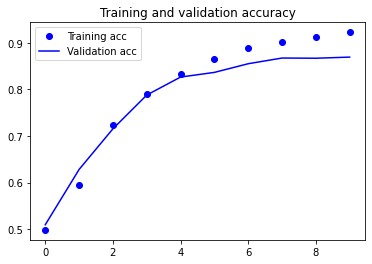

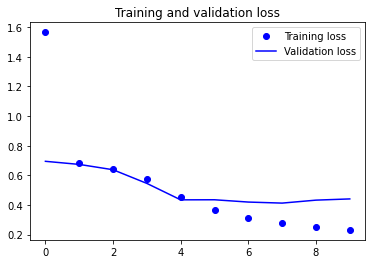

In [13]:
#繪製結果
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [16]:
#檢視耶拿天氣資料集的資料
data_dir = '../input/jena-climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',') #天氣資料項目
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [17]:
#解析資料
float_data = np.zeros((len(lines), len(header) - 1)) #不放入日期
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]] #不放入日期
    float_data[i, :] = values
print(float_data.shape)

(420551, 14)


In [18]:
#標準化資料
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [19]:
#定義資料產生器，產生tuple資料集(samples 樣本數, targets 目標值)，樣本數samples對應批次量的天氣資料，目標數targets對應目標溫度陣列
#data:原始浮點數資料，並經標準化
#lookback:輸入資料應回溯多少個時間點
#delay:目標溫度應在未來多少個時間點
#min_index、max_index:資料陣列中最小與最大索引值，用以劃分時間點，來界定訓練集、驗證集和測試集
#shuffle:是否按時間順序使用樣本或打亂樣本
#batch_size = 每批次的樣本數量
#step = 產生樣本資料的時間區隔(以時間點為單位)，目前設定為6，也就是每小時取一資料點

def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay
    
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows), ))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
            
        yield samples, targets

In [20]:
#為耶拿數據集準備高解析率的資料產生器
step = 3 #每30分鐘一個時間點
lookback = 720
delay = 144

#訓練資料產生器
train_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=0,
                     max_index=200000,
                     shuffle=True,
                     step=step)

#驗證資料產生器
val_gen = generator(float_data,
                   lookback=lookback,
                   delay=delay,
                   min_index=200001,
                   max_index=300000,
                   step=step)

#測試資料產生器
test_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=300001,
                    max_index=None,
                    step=step)

In [22]:
val_steps = (300000 - 200001 - lookback) // 128 #val_gen產生器需運行多少次才可產生完整的驗證集
test_steps = (len(float_data) - 300001 - lookback) // 128 #test_gen產生器需運行多少次才可產生完整的驗證集

In [14]:
#卷積神經網路對資料中局部區塊進行特徵萃取，但局部外就難產生關連，無法知道彼此之間的關係
#結合CNN和RNN來處理長序列資料
#卷積神經網路先將長時間輸入序列資料轉換為較短(部分採樣)的高階特徵序列資料，這些萃取出的特徵序列資料再做為RNN神經網路輸入

In [23]:
#結合1D卷積層和GRU層的模型
model = models.Sequential()
model.add(layers.Conv1D(32, 5, activation='relu', input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru (GRU)                    (None, 32)                6336      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 13,793
Trainable params: 13,793
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.compile(optimizer=optimizers.RMSprop(),
             loss='mae')

In [26]:
model.fit_generator(train_gen, #samples.shape=(128,720/3=240,14), targets.shape=(128, )
                   steps_per_epoch=500,
                   epochs=20,
                   validation_data=val_gen,
                   validation_steps=val_steps)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
500/500 [==============================] - 153s 301ms/step - loss: 0.3324 - val_loss: 0.3016
Epoch 2/20
500/500 [==============================] - 148s 297ms/step - loss: 0.2955 - val_loss: 0.2805
Epoch 3/20
500/500 [==============================] - 145s 291ms/step - loss: 0.2824 - val_loss: 0.2792
Epoch 4/20
500/500 [==============================] - 145s 289ms/step - loss: 0.2720 - val_loss: 0.2800
Epoch 5/20
500/500 [==============================] - 143s 286ms/step - loss: 0.2642 - val_loss: 0.2819
Epoch 6/20
500/500 [==============================] - 145s 289ms/step - loss: 0.2594 - val_loss: 0.2850
Epoch 7/20
500/500 [==============================] - 143s 287ms/step - loss: 0.2505 - val_loss: 0.2848
Epoch 8/20
500/500 [==============================] - 144s 288ms/step - loss: 0.2437 - val_loss: 0.3034
Epoch 9/20
500/500 [==============================] - 146s 291ms/step - loss: 0.2378 - val_loss: 0.2886
Epoch 10/20
500/500 [==============================] - 149s 299m

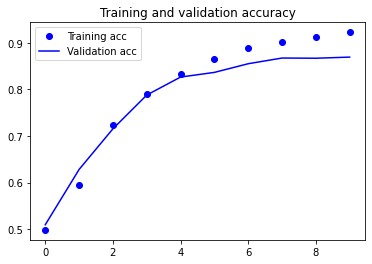

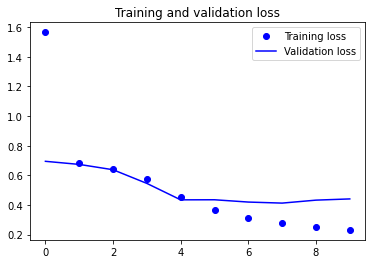

In [27]:
#繪製結果
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [28]:
#從驗證的損失來看，此方法不如單獨的正規化GRU好，但執行速度明顯更快，且可檢視兩倍的資料。